In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dipy.core.gradients as dpg
import dipy.data as dpd
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from dipy.segment.mask import median_otsu
import nibabel as nib
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti

/Users/arokem/source/scikit-image/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
import tools

In [4]:
import dipy.data as dpd

In [5]:
img, gtab = dpd.read_cenir_multib()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/cenir_multib 


In [6]:
data = img.get_data()

In [7]:
s0 = np.mean(data[..., gtab.b0s_mask], -1)

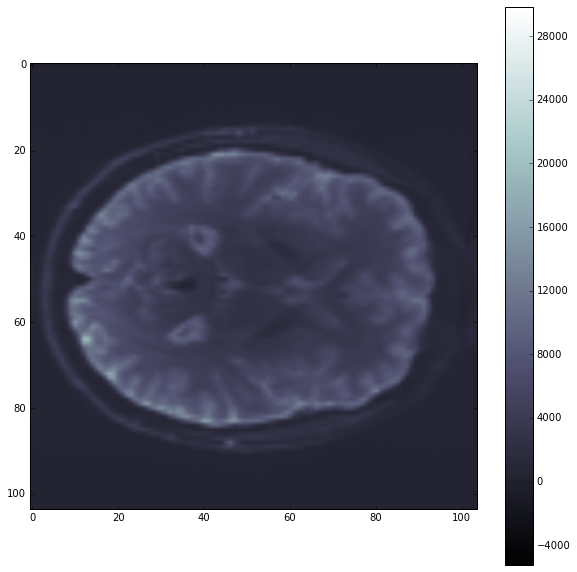

In [8]:
tools.make_widget(s0, dims=3)

In [9]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

In [10]:
vol = np.zeros(mask.shape)
vol[mask] = s0[mask]

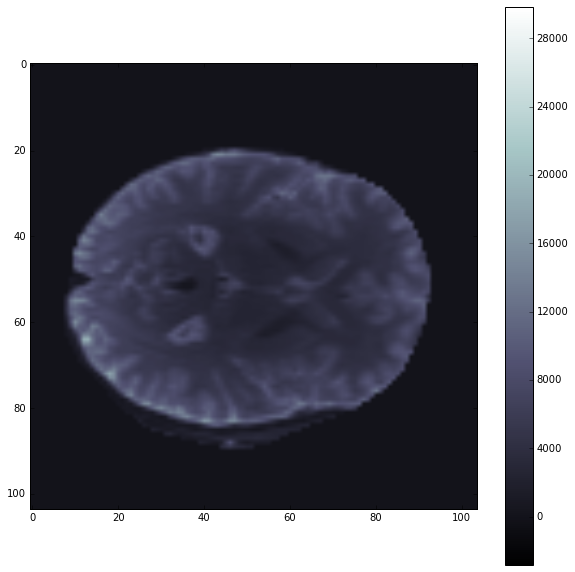

In [11]:
tools.make_widget(vol, dims=3)

In [12]:
low_bvals_idx = gtab.bvals < 990
data_low_bvals = data[..., low_bvals_idx]
gtab_low_bvals = dpg.gradient_table(gtab.bvals[low_bvals_idx], gtab.bvecs[low_bvals_idx])

In [13]:
ten_model_low_bvals = dti.TensorModel(gtab_low_bvals)
ten_fit_low_bvals = ten_model_low_bvals.fit(data_low_bvals, mask=mask)

In [14]:
idx_1000 = np.logical_and(gtab.bvals > 990, gtab.bvals < 1010)
idx_2000 = np.logical_and(gtab.bvals > 1010, gtab.bvals < 2100)
idx_3000 = gtab.bvals > 2100

In [15]:
data_3000 = data[..., idx_3000]

In [16]:
gtab_3000 = dpg.gradient_table(gtab.bvals[idx_3000], gtab.bvecs[idx_3000])

In [17]:
pred_3000 = ten_fit_low_bvals.predict(gtab_3000, S0=s0)

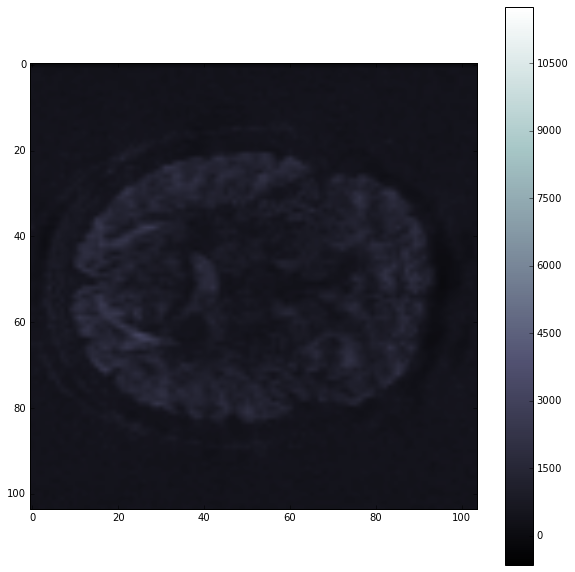

In [18]:
tools.make_widget(data_3000)

In [19]:
# Set values outside the mask to 0 (otherwise, we get some weird effects close to the mask (high S0?))
pred_3000[np.where(~mask)] = 0

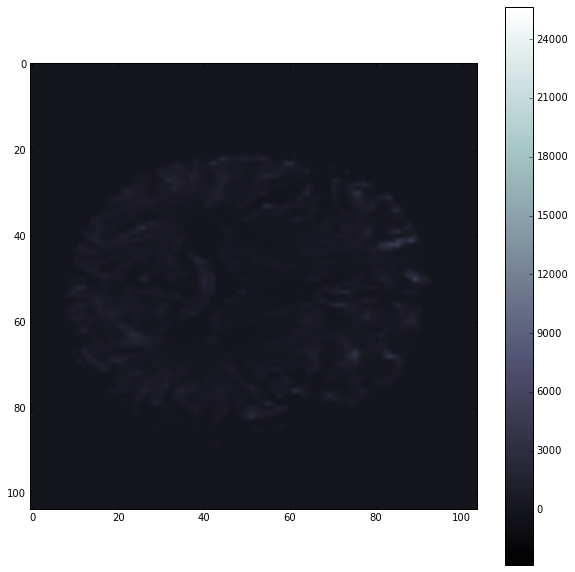

In [20]:
tools.make_widget(pred_3000)

In [21]:
reg = []
aff = []
for ii in range(pred_3000.shape[-1])[:5]:
    r, a = tools.affine_registration(data_3000[..., ii], 
                                     pred_3000[..., ii], 
                                     pipeline=[tools.affine])
    reg.append(r)
    aff.append(a)
    

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [22]:
data_xform_3000 = np.swapaxes(np.swapaxes(np.swapaxes(np.array(reg), 0, -1), 0, 2), 0, 1)
affines_3000 = np.array(aff)
# The following will only work if we register all volumes: 
# xform_gtab_3000 = dpg.reorient_bvecs(gtab_3000, affines_3000)

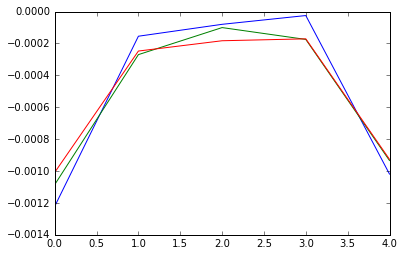

In [23]:
plt.plot(affines_3000[:, :3, 3])

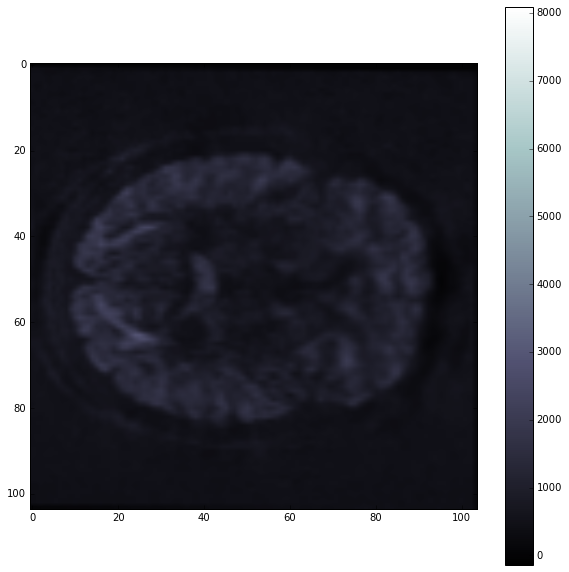

In [24]:
tools.make_widget(data_xform_3000)